## Detecting Plant Disease

Welcome to my notebook!

In recent decades, farmers have experienced devastating crop loss as a result of the changes in the environment; global warming, weather pattern changes, pest infestations, etc. According to PlantVillage source, we need to increase food production globally by 70% to feed an expected population of 9 billion people. This project aims to predict whether a crop is healthy or not and aid in PlantVillage's mobile disease diagnostics system! Early detection of disease is key for preventing the loss of a crop. It is especially import to salvage crops in developing communities.

Throughout this notebook, I will load in the necesarry libraries and the PlantVillage dataset. The PlantVillage dataset includes images of several leaves of 38 different types of crops. 

I will iterate over several models to make predictions for healthy and diseased plants. 

### Loading in the data

Load in the necessary libraries. 

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,Activation,LeakyReLU,BatchNormalization,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import pickle
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer,MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, LSTM, AveragePooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from timeit import default_timer as timer
from pathlib import Path
import imagesize
from PIL import Image

from utils import get_roots, healthy_images, all_images, image_sizes, create_df, plot results, predict_disease

First, I'll set some defaults to add into models easier

In [2]:
EPOCHS = 25
LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '../PlantVillage-Dataset/raw/'
width=256
height=256
depth=3

Created a function to convert images to an array to feed into a model. 

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Loading in the images and their classes. 

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")


[INFO] Loading images ...
[INFO] Processing Strawberry___healthy ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Tomato_mosaic_virus ...
[INFO] Processing Pepper,_bell___healthy ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Grape___Esca_(Black_Me

In [5]:
image_size = len(image_list)
image_size

22656

### EDA

In this portion, I'll perform some exploratory data analysis, looking into the sizes of the images and the balance in types of images in this dataset. 

In [6]:
#First I'll define three roots that represent the 3 folders: color, grayscale, and segmented.
root = '../PlantVillage-Dataset/raw/color/'
root2 = '../PlantVillage-Dataset/raw/grayscale/'
root3 = '../PlantVillage-Dataset/raw/segmented/'

In [18]:
# Define a function that will get the file path for the 3 folders. 
def get_roots(root_, root2_, root3_): 
    # Get the color root 
    all_color = []
    for x in plant_disease_folder_list:     
            all_color.append(f'{root}{x}/')
        
    # Get the grayscale root
    all_gray = []
    for y in plant_disease_folder_list:     
            all_gray.append(f'{root2}{y}/')
            
    # Get the segmented root
    all_seg = []
    for z in plant_disease_folder_list:     
            all_seg.append(f'{root3}{z}/')
            
    # Sanity Check
    return [all_color, all_gray, all_seg]

In [26]:
# create a list containing the filepaths for each of the 3 folders. 
all_roots_list = get_roots(root, root2, root3)
all_roots_color = all_roots_list[0]
all_roots_gray = all_roots_list[1]
all_roots_seg = all_roots_list[2]

print(all_roots_color[0])
print(all_roots_gray[0])
print(all_roots_seg[0])

../PlantVillage-Dataset/raw/color/Strawberry___healthy/
../PlantVillage-Dataset/raw/grayscale/Strawberry___healthy/
../PlantVillage-Dataset/raw/segmented/Strawberry___healthy/


Now, I'll look into the folders that contain healthy images. 

In [46]:
#Define a function that will grab the healthy folders from color, grayscale, 
#and segmented folders. 
def healthy_images(color, gray, seg): 
    
    healthy_col = []
    for x in color: 
        if x[-8:] == 'healthy/': 
            healthy_col.append(x)

    # Check the grayscale image labels    
    healthy_gray = []
    for y in gray: 
        if y[-8:] == 'healthy/': 
            healthy_gray.append(y)

    # Check the segmented image labels  
    healthy_seg = []
    for z in seg: 
        if z[-8:] == 'healthy/': 
            healthy_seg.append(z)
            
    return [healthy_col, healthy_gray, healthy_seg]

In [55]:
# Show a preview of the filepaths that show healthy images. 
healthy_list = healthy_images(all_roots_color, all_roots_gray, all_roots_seg)

healthy_images_col = healthy_list[0]
healthy_images_gray = healthy_list[1]
healthy_images_seg = healthy_list[2]

print(healthy_images_col[1])
print(healthy_images_gray[1])
print(healthy_images_seg[1])

../PlantVillage-Dataset/raw/color/Blueberry___healthy/
../PlantVillage-Dataset/raw/grayscale/Blueberry___healthy/
../PlantVillage-Dataset/raw/segmented/Blueberry___healthy/


I'll create a function that gets the filepath for every image that I'll later add to a DataFrame

In [63]:
# Function that gets all of the image paths from each folder. 
def all_images(col_, gray_, seg_): 
    
    #List of color images
    total_col_ = []
    for q in range(38):
        for img1 in Path(col_[q]).iterdir(): 
            if img1.suffix == ".JPG": 
                total_col_.append(f'{img1}')
        
    # List of grayscale images
    total_gray_ = []
    for r in range(38):
        for img2 in Path(gray_[r]).iterdir(): 
            if img2.suffix == ".JPG": 
                total_gray_.append(f'{img2}')
                
    # List of segmented images 
    total_seg_ = []
    for s in range(38):
        for img3 in Path(seg_[s]).iterdir(): 
             if img3.suffix == ".jpg": 
                total_seg_.append(f'{img3}')
    
    return [total_col_, total_gray_, total_seg_]

In [67]:
# Print a preview of the filepaths and the amount of images in each folder. 
all_roots_list = all_images(all_roots_color, all_roots_gray, all_roots_seg)

total_col = all_roots_list[0]
total_gray = all_roots_list[1]
total_seg = all_roots_list[2]

# Sanity Check  
print(total_col[52000])
print(total_gray[52000])
print(total_seg[0])
# Total number of images
print(len(total_col))
print(len(total_gray))
print(len(total_seg))

../PlantVillage-Dataset/raw/color/Soybean___healthy/b25561af-8ae8-49a6-ac2a-f6c1729b3638___RS_HL 4582.JPG
../PlantVillage-Dataset/raw/grayscale/Soybean___healthy/b25561af-8ae8-49a6-ac2a-f6c1729b3638___RS_HL 4582.JPG
../PlantVillage-Dataset/raw/segmented/Strawberry___healthy/091b0459-1a9a-4a60-b59f-3de2faedb6f8___RS_HL 2101_final_masked.jpg
52803
52803
54306


Here, I'll define a function that gets the image sizes of each folder

In [70]:
#Function that shows all the image sizes of each folder. 
def image_sizes(root_col, root_gray, root_seg): 
    
    #Get sizes of color images
    image_sizes_col_ = []
    for a in range(len(root_col)):
        im = Image.open(root_col[a])
        image_sizes_col_.append(im.size)
    
    #Get sizes of grayscale images
    image_sizes_gray_ = []
    for b in range(len(root_gray)):
        im2 = Image.open(root_gray[b])
        image_sizes_gray_.append(im2.size)
        
    #Get sizes of segmented images
    image_sizes_seg_ = []
    for c in range(len(root_seg)):
        im3 = Image.open(root_seg[c])
        image_sizes_seg_.append(im3.size)
    
    return [image_sizes_col_, image_sizes_gray_, image_sizes_seg_]


In [72]:
# Print a preview of the image sizes in each folder. 
total_img_sizes = image_sizes(total_col, total_gray, total_seg)

image_sizes_col = total_img_sizes[0]
image_sizes_gray = total_img_sizes[1]
image_sizes_seg = total_img_sizes[2]

print(image_sizes_col[0])
print(image_sizes_gray[0])
print(image_sizes_seg[0])

(256, 256)
(256, 256)
(256, 256)


Define a function that will create a DataFrame containing the image sizes, file names, and types of images in each folder. 

In [80]:
def create_df(col_sizes, col_roots, gray_sizes, gray_roots, seg_sizes, seg_roots): 
    # Create a DataFrame with image Width, Height, FileName, and Type. 
    # Color first 
    col_image_df = pd.DataFrame(col_sizes, columns=('Width', 'Height'))
    col_image_df['FileName'] = col_roots
    col_image_df['Type'] = col_image_df['FileName'].str.contains('healthy')
    col_image_df['Type'] = col_image_df['Type'].astype('object')
    col_image_df['Type'].replace(True, 'Healthy', inplace=True)
    col_image_df['Type'].replace(False, 'Disease', inplace=True)
    
    # Grayscale DataFrame
    gray_image_df = pd.DataFrame(gray_sizes, columns=('Width', 'Height'))
    gray_image_df['FileName'] = gray_roots
    gray_image_df['Type'] = gray_image_df['FileName'].str.contains('healthy')
    gray_image_df['Type'] = gray_image_df['Type'].astype('object')
    gray_image_df['Type'].replace(True, 'Healthy', inplace=True)
    gray_image_df['Type'].replace(False, 'Disease', inplace=True)


    # Segmented DataFrame
    seg_image_df = pd.DataFrame(seg_sizes, columns=('Width', 'Height'))
    seg_image_df['FileName'] = seg_roots
    seg_image_df['Type'] = seg_image_df['FileName'].str.contains('healthy')
    seg_image_df['Type'] = seg_image_df['Type'].astype('object')
    seg_image_df['Type'].replace(True, 'Healthy', inplace=True)
    seg_image_df['Type'].replace(False, 'Disease', inplace=True)

    #Concatenate DataFrames
    return pd.concat([col_image_df, gray_image_df, seg_image_df], axis=0)

In [83]:
# Preview the DataFrame and the data info. 
image_df = create_df(image_sizes_col, 
                     total_col, 
                     image_sizes_gray,
                     total_gray, 
                     image_sizes_seg,
                     total_seg)

print(image_df.head())
print(image_df.info())

   Width  Height                                           FileName     Type
0    256     256  ../PlantVillage-Dataset/raw/color/Strawberry__...  Healthy
1    256     256  ../PlantVillage-Dataset/raw/color/Strawberry__...  Healthy
2    256     256  ../PlantVillage-Dataset/raw/color/Strawberry__...  Healthy
3    256     256  ../PlantVillage-Dataset/raw/color/Strawberry__...  Healthy
4    256     256  ../PlantVillage-Dataset/raw/color/Strawberry__...  Healthy
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159912 entries, 0 to 54305
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Width     159912 non-null  int64 
 1   Height    159912 non-null  int64 
 2   FileName  159912 non-null  object
 3   Type      159912 non-null  object
dtypes: int64(2), object(2)
memory usage: 6.1+ MB
None


### Visualizations

Here, we can see a preview of a few images from each folder, and visualizations using Plotly that examine the image sizes and the imbalance in the types of images. 

In [84]:
#Function to take in an image path and display the image. 
def show_im(im_list): 
    im = Image.open(im_list[8])
    print(im.size)
    display(im)

(256, 256)


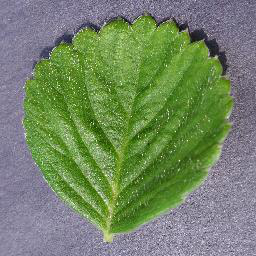

(256, 256)


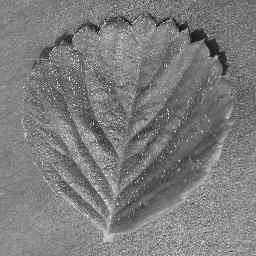

(256, 256)


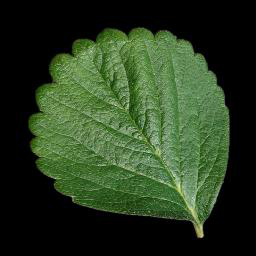

In [85]:
#Preview 3 images from each folder. 
show_im(total_col)
show_im(total_gray)
show_im(total_seg)

In [86]:
# Visualization showing image sizes. 
fig = px.histogram(image_df, 
                   y='Width', 
                   x='Height', 
                   color='Type',
                   color_discrete_sequence=px.colors.sequential.Agsunset_r,
                   template='plotly_dark')

fig.show()

Above we can see that almost all the images are the same size except for a few outliers. 

In [87]:
fig1 = px.bar(image_df, 
             y=image_df['Type'].value_counts().index,
             x=list(image_df['Type'].value_counts()),
             color=list(image_df['Type'].value_counts().index), 
             orientation='h',
             color_discrete_sequence=px.colors.sequential.Agsunset_r, 
             template='plotly_dark'
            )

fig1.show()

Here we can visualize the imbalance of healthy and diseased plant images in the dataset. 

### Data Prep for Modeling

Get labels from the images

In [14]:
# Use LabelBinarizer to get class labels of data 
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

In [15]:
# Divide by 255 for RGB values. 
start = timer()

np_image_list = np.array(image_list, dtype=np.float16) / 255.0

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Total Time Elapsed:  2  minutes  17  seconds


In [16]:
#Split data to train and test with an 80/20 split 
X_train, X_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

In [17]:
# Check out the length of train and test data. 
print(len(X_train))
print(len(X_test))

18124
4532


### First Simple Model

First, I'll start with a very very simple model. The first layer is a Conv2D layer using the relu activation function. Relu is useful over tanh and sigmoid in the topmost layers because it makes the model easier to train and often the model achieves better performance. Setting 'same' to padding extends the area at which CNN processes an image. We also make sure to set our input shape. 

In [18]:
#Start with a CNN 
model = Sequential()
inputShape = (height, width, depth)
#Frist Convolutional layer
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
#Flatten the images to put them into one long array 
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
#Check on the summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 231200)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              236749824 
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0

Augment the images and see it's affect on the model's performance afterwards. Here I'll 
add in a few different changes to augment the images including a horizontal flip.

In [94]:
 aug = ImageDataGenerator(
    rotation_range=50, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    )

Compile this model with binary crossentropy since this is a binary classification problem, 
and accuracy as the metric 

In [20]:
model.compile(loss="binary_crossentropy", metrics=["accuracy"])

Train the model! 

In [21]:
#Add in the timer for the model to be printed once the model has stopped running. 
start = timer()

history = model.fit(
          aug.flow(X_train, y_train),
          validation_data=(X_test, y_test),
          steps_per_epoch=20,
          epochs=10, 
          verbose=1, 
)

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/10
20/20 [==============================] - 96s 5s/step - loss: 0.7340 - accuracy: 0.0250 - val_loss: 0.7822 - val_accuracy: 0.0309
Epoch 2/10
20/20 [==============================] - 56s 3s/step - loss: 0.5425 - accuracy: 0.0375 - val_loss: 0.1425 - val_accuracy: 0.0382
Epoch 3/10
20/20 [==============================] - 57s 3s/step - loss: 0.1220 - accuracy: 0.0422 - val_loss: 0.1199 - val_accuracy: 0.0565
Epoch 4/10
20/20 [==============================] - 56s 3s/step - loss: 0.1160 - accuracy: 0.0891 - val_loss: 0.1186 - val_accuracy: 0.0905
Epoch 5/10
20/20 [==============================] - 59s 3s/step - loss: 0.1165 - accuracy: 0.1094 - val_loss: 0.1100 - val_accuracy: 0.1335
Epoch 6/10
20/20 [==============================] - 55s 3s/step - loss: 0.1120 - accuracy: 0.1312 - val_loss: 0.1170 - val_accuracy: 0.1333
Epoch 7/10
20/20 [==============================] - 55s 3s/step - loss: 0.1090 - accuracy: 0.1453 - val_loss: 0.1232 - val_accuracy: 0.1406
Epoch 8/10
20/20 [==

Above, we can see the model ran for 11 minutes. 

Below, we'll evaluate the model's performance. 

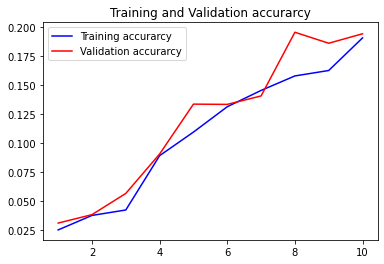

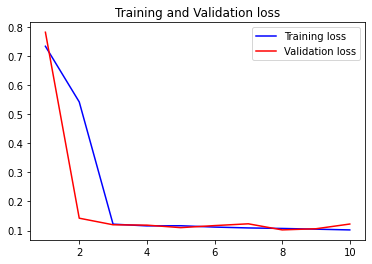

[INFO] Calculating model accuracy
142/142 [==============================] - 26s 186ms/step - loss: 0.1224 - accuracy: 0.1942
Test Accuracy: 19%


In [22]:
# Evaluate Model. Comparing the accuracy and loss by plotting the graph for training 
# and validation.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

"""Evaluating model accuracy by using the `evaluate` method"""

print("[INFO] Calculating model accuracy")
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {round(scores[1]*100)}%")

 The accuracy comes out low at about 19%, leaving a lot of room for improvement in the modeling process. Due to limited computing power, I wanted to check on how a model would perform by keeping the epochs and steps per epoch on the lower side at 10 epochs and 20 steps per epoch. When visualizing the model's epochs and validation accuracy, a gradual improvement does show, so adding more epochs and steps per epoch may drastically improve this model's accuracy.

### Second Model

Let's try again.

In [23]:
#Create a CNN 
model_2 = Sequential()
inputShape = (height, width, depth)
# Add in the convolutional layer. 
model_2.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model_2.add(Activation("relu"))
model_2.add(MaxPooling2D(pool_size=(3, 3)))
model_2.add(Dropout(0.25))
#Flatten the images 
model_2.add(Flatten())
model_2.add(Dense(1024))
model_2.add(Activation("relu"))
model_2.add(Dropout(0.5))
model_2.add(Dense(n_classes))
model_2.add(Activation("softmax"))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_3 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 231200)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              236749824 
_________________________________________________________________
activation_4 (Activation)    (None, 1024)             

In [24]:
model_2.compile(loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
aug = ImageDataGenerator(
      rotation_range=25, 
      width_shift_range=0.1,
      height_shift_range=0.1, 
      shear_range=0.2, 
      zoom_range=0.2, 
      horizontal_flip=True 
    )

This time around, I'll add more steps per epoch and evaluate the model afterwards. 

In [26]:
start = timer()

history_2 = model_2.fit(
            aug.flow(X_train, y_train),
            validation_data=(X_test, y_test),
            steps_per_epoch=100,
            epochs=10, 
            verbose=1, 
)

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/10
100/100 [==============================] - 219s 2s/step - loss: 0.7737 - accuracy: 0.0321 - val_loss: 0.7850 - val_accuracy: 0.0276
Epoch 2/10
100/100 [==============================] - 209s 2s/step - loss: 0.2545 - accuracy: 0.0591 - val_loss: 0.1212 - val_accuracy: 0.1130
Epoch 3/10
100/100 [==============================] - 208s 2s/step - loss: 0.1088 - accuracy: 0.1550 - val_loss: 0.1094 - val_accuracy: 0.2107
Epoch 4/10
100/100 [==============================] - 179s 2s/step - loss: 0.0996 - accuracy: 0.2262 - val_loss: 0.1015 - val_accuracy: 0.2884
Epoch 5/10
100/100 [==============================] - 189s 2s/step - loss: 0.0961 - accuracy: 0.2459 - val_loss: 0.0917 - val_accuracy: 0.3155
Epoch 6/10
100/100 [==============================] - 190s 2s/step - loss: 0.0916 - accuracy: 0.2831 - val_loss: 0.0881 - val_accuracy: 0.3572
Epoch 7/10
100/100 [==============================] - 178s 2s/step - loss: 0.0893 - accuracy: 0.3038 - val_loss: 0.0996 - val_accuracy: 0.3369

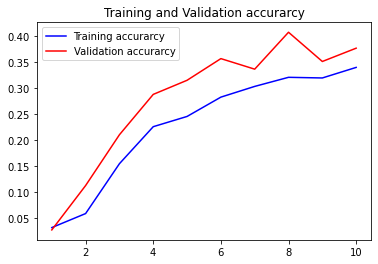

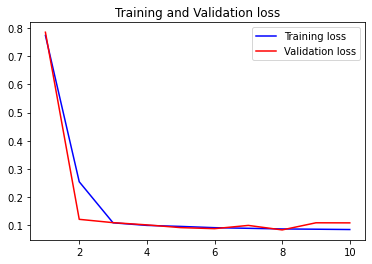

[INFO] Calculating model accuracy
142/142 [==============================] - 23s 160ms/step - loss: 0.1086 - accuracy: 0.3773
Test Accuracy: 37.73168623447418


In [27]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

"""Evaluating model accuracy by using the `evaluate` method"""

print("[INFO] Calculating model accuracy")
scores = model_2.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

Above we can see the model had an improvement from 19% test accuracy to now about 38% test accuracy! 

### Third Model

For the third model, we'll add a bit more. I'll ad a few more Conv2 layers gradually increasing the sizes from 32 up to 128, and again flattening the images. 

In [28]:
#Create a CNN 
model_3 = Sequential()
inputShape = (height, width, depth)
#Add a Conv2 Layer
model_3.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model_3.add(Activation("relu"))
model_3.add(MaxPooling2D(pool_size=(3, 3)))
model_3.add(Dropout(0.25))
#Add again, increasing size
model_3.add(Conv2D(64, (3, 3), padding="same"))
model_3.add(Activation("relu"))
#Add again 
model_3.add(Conv2D(64, (3, 3), padding="same"))
model_3.add(Activation("relu"))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))
#Add again, increasing size 
model_3.add(Conv2D(128, (3, 3), padding="same"))
model_3.add(Activation("relu"))
#Add again 
model_3.add(Conv2D(128, (3, 3), padding="same"))
model_3.add(Activation("relu"))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))
#Flatten images 
model_3.add(Flatten())
model_3.add(Dense(1024))
model_3.add(Activation("relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(n_classes))
model_3.add(Activation("softmax"))
#Check the summary. 
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 85, 85, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 85, 85, 64)       

Here, I augment the images slightly differently by using a vertical flip. 

In [29]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2, vertical_flip=True 
    )

In [ ]:
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)

In [30]:
model_3.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [31]:
start = timer()

history_3 = model_3.fit(
          aug.flow(X_train, y_train, batch_size=BS),
          validation_data=(X_test, y_test),
          steps_per_epoch=len(X_train) // BS,
          epochs=15, 
          verbose=1
)

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/15
566/566 [==============================] - 864s 2s/step - loss: 0.1213 - accuracy: 0.0353 - val_loss: 0.1203 - val_accuracy: 0.0430
Epoch 2/15
566/566 [==============================] - 824s 1s/step - loss: 0.1016 - accuracy: 0.1846 - val_loss: 0.1057 - val_accuracy: 0.1933
Epoch 3/15
566/566 [==============================] - 830s 1s/step - loss: 0.0851 - accuracy: 0.3154 - val_loss: 0.0933 - val_accuracy: 0.2921
Epoch 4/15
566/566 [==============================] - 827s 1s/step - loss: 0.0757 - accuracy: 0.4000 - val_loss: 0.0788 - val_accuracy: 0.3877
Epoch 5/15
566/566 [==============================] - 825s 1s/step - loss: 0.0673 - accuracy: 0.4625 - val_loss: 0.0824 - val_accuracy: 0.3972
Epoch 6/15
566/566 [==============================] - 822s 1s/step - loss: 0.0616 - accuracy: 0.5116 - val_loss: 0.0775 - val_accuracy: 0.4296
Epoch 7/15
566/566 [==============================] - 859s 2s/step - loss: 0.0564 - accuracy: 0.5544 - val_loss: 0.0650 - val_accuracy: 0.5115

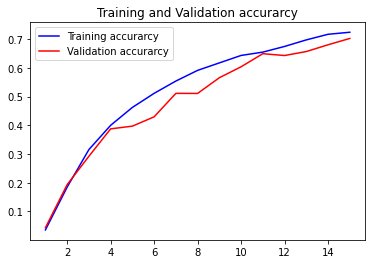

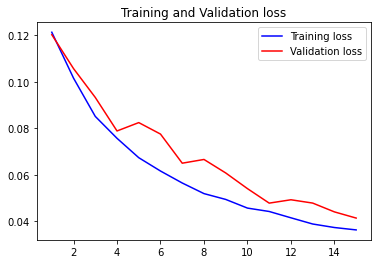

[INFO] Calculating model accuracy
142/142 [==============================] - 39s 275ms/step - loss: 0.0413 - accuracy: 0.7030
Test Accuracy: 70.30009031295776


In [32]:
"""# Evaluate Model
Comparing the accuracy and loss by plotting the graph for training and validation.
"""

acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

"""Evaluating model accuracy by using the `evaluate` method"""

print("[INFO] Calculating model accuracy")
scores = model_3.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

Wow, another drastic improvement up from 38%. The test accuracy now shows about 70%! There's still room for improvement, so we'll continue on to another model. 

### Fourth Model

In [33]:
model_4 = Sequential()
inputShape = (height, width, depth)

model_4.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model_4.add(Activation("relu"))
model_4.add(MaxPooling2D(pool_size=(3, 3)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(64, (3, 3), padding="same"))
model_4.add(Activation("relu"))

model_4.add(Conv2D(64, (3, 3), padding="same"))
model_4.add(Activation("relu"))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(128, (3, 3), padding="same"))
model_4.add(Activation("relu"))

model_4.add(Conv2D(128, (3, 3), padding="same"))
model_4.add(Activation("relu"))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(256, (3, 3), padding="same"))
model_4.add(Activation("relu"))

model_4.add(Conv2D(256, (3, 3), padding="same"))
model_4.add(Activation("relu"))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Flatten())
model_4.add(Dense(1024))
model_4.add(Activation("relu"))
model_4.add(Dropout(0.5))
model_4.add(Dense(n_classes))
model_4.add(Activation("softmax"))

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_13 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_14 (Activation)   (None, 85, 85, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 85, 85, 64)       

In [34]:
model_4.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [20]:
start = timer()

history_4 = model_4.fit(
          aug.flow(X_train, y_train, batch_size=BS),
          validation_data=(X_test, y_test),
          steps_per_epoch=len(X_train) // BS,
          epochs=EPOCHS, 
          verbose=1
)

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/25
566/566 [==============================] - 973s 2s/step - loss: 0.1225 - accuracy: 0.0336 - val_loss: 0.1205 - val_accuracy: 0.0435
Epoch 2/25
566/566 [==============================] - 939s 2s/step - loss: 0.1137 - accuracy: 0.0974 - val_loss: 0.1201 - val_accuracy: 0.1624
Epoch 3/25
566/566 [==============================] - 935s 2s/step - loss: 0.0980 - accuracy: 0.2153 - val_loss: 0.0999 - val_accuracy: 0.2312
Epoch 4/25
566/566 [==============================] - 904s 2s/step - loss: 0.0875 - accuracy: 0.3099 - val_loss: 0.0887 - val_accuracy: 0.3795
Epoch 5/25
566/566 [==============================] - 873s 2s/step - loss: 0.0775 - accuracy: 0.3912 - val_loss: 0.0850 - val_accuracy: 0.4393
Epoch 6/25
566/566 [==============================] - 907s 2s/step - loss: 0.0717 - accuracy: 0.4354 - val_loss: 0.0696 - val_accuracy: 0.5254
Epoch 7/25
566/566 [==============================] - 1006s 2s/step - loss: 0.0680 - accuracy: 0.4712 - val_loss: 0.0652 - val_accuracy: 0.521

In [ ]:
"""# Evaluate Model
Comparing the accuracy and loss by plotting the graph for training and validation.
"""

acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

"""Evaluating model accuracy by using the `evaluate` method"""

print("[INFO] Calculating model accuracy")
scores = model_4.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

### Predictions

In [ ]:
def predict_disease(image_path, estimator):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = estimator.predict_classes(np_image)
    print((label_binarizer.classes_[result][0]))

Apple___Cedar_apple_rust


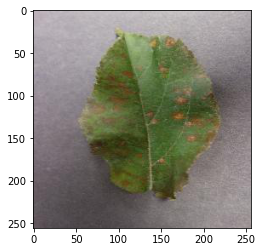

In [30]:
path = '../1Capstone1/PlantVillage-Dataset/raw/color/Apple___Cedar_apple_rust/0340baaa-e9cc-4c04-8f9b-c204180d9ae3___FREC_C.Rust 3805.JPG'
predict_disease(path, model_3)

Blueberry___healthy


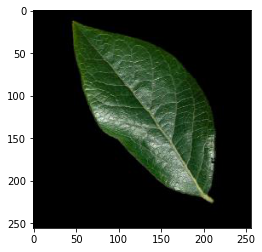

In [33]:
path = '../1Capstone1/PlantVillage-Dataset/raw/segmented/Blueberry___healthy/011405e4-a92a-44b6-9f04-10fec28d93f5___RS_HL 2311_final_masked.jpg'
predict_disease(path, model_3)

### Conclusion 

The final model I'll choose will be the 3rd model. The accuracy performs the best on this data at 70%.

Continuing work on this project, I'd like to next explore different types of models that may improve the performance like XGBoost!

In future work, I'd like to include more images in the dataset that are common in other parts of the world. The fruits and vegetables in this dataset are very common in North America, and I'd like to include images representing the vegetation that is common to the cultures in other countries other than North America. I'd also want to shoot for a more balanced dataset that contains more healthy plant images to help with that imbalance in healthy vs. diseased images.